# SEIRD Model Inference

In this notebook we present how to use the `epimodels` module to set up the inference for some of the parameters of the SEIRD model. We aim to explore the indetifiability of the parameters we use to simulate the model.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**, using toy data;
 - PHE regions of interest: **South West**.

We use synthetically generated serology and mortality data from simulated model.

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(128)

## Model Setup
### Define setup matrices for the Roche Model

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.SEIRDModel()

# Set the region names of the model
model.set_regions(regions)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = np.sum(total_susceptibles[1])

# Initial number of infectives
infectives = [100]

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Probability of death
Pd = np.sum(np.multiply(total_susceptibles[1], pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values)) / susceptibles

In [4]:
# Set ICs parameters
ICs = em.SEIRDICs(
    model=model,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros(len(regions)).tolist(),
    infectives_IC=infectives,
    recovered_IC=np.zeros(len(regions)).tolist(),
    dead_IC=np.zeros(len(regions)).tolist()
)

# Set transmission parameters
transmission_parameters = em.SEIRDTransmission(
    model=model,
    beta=5,
    kappa=0.25,
    gamma=0.25,
    Pd = Pd
)

# Set other simulation parameters
simulation_parameters = em.SEIRDSimParameters(
    model=model,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
parameters = em.SEIRDParametersController(
    model=model,
    ICs=ICs,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

### Simulate for one of the regions: **South West**

In [5]:
# Simulate for all regions
output = []
new_infec = []
new_deaths = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output.append(model.simulate(parameters))
    new_infec.append(model.new_infections(output[-1]))
    new_deaths.append(model.new_deaths(output[-1]))

## Death and Serology data
### Read Tests data

In [6]:
# Read in tests data from external files for realistic counts of tests
tests = []

for region in regions:
    daily_tests = np.ones((len(times), len(age_groups)), dtype=int)
    weekly_tests = np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=',')
    for _, day in enumerate(np.arange(0, len(times), 7)):
        daily_tests[day:(day+7), :]=weekly_tests[_, :] / 7
    tests.append(np.sum(daily_tests, axis=1))

In [7]:
# Set information
niu = 10**(-5) # float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

### Sample Death and Serology data

In [8]:
# Sample death and positive test results data for all regions
deaths_data = []
positives_data = []

for r, reg in enumerate(regions):
    reg_deaths_data = np.empty(len(times))
    reg_positives_data = np.empty(len(times))
    for t, _ in enumerate(times):
        # Sample the number of deaths and positive test results in a given region on a given day
        reg_deaths_data[t] = model.samples_deaths(new_deaths[r], niu, t)
        reg_positives_data[t] = model.samples_positive_tests(output[r], tests[r][t], sens, spec, t)
    deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
    positives_data.append(np.asarray(reg_positives_data, dtype=int))

### Export Death and Serology data

In [9]:
# Export synthetic death and positive test results data for all regions to external files to save computation time
path_ = 'inference_data/'

for r, region in enumerate(regions):
    path = os.path.join(path_, '{}_Syn_Deaths.csv'.format(region))
    path1 = os.path.join(path_, '{}_Syn_Positives.csv'.format(region))

    np.savetxt(path, deaths_data[r], fmt="%d", delimiter=',')
    np.savetxt(path1, positives_data[r], fmt="%d",  delimiter=',')

### Read Death and Serology data

In [10]:
# Read in synthetic death and positive data from external files
deaths_data = []
positives_data = []

for region in regions:
    deaths_data.append(np.loadtxt('inference_data/{}_Syn_Deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('inference_data/{}_Syn_Positives.csv'.format(region), dtype=int, delimiter=','))

In [11]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(1, total_days+1, 1).tolist()
serology_times = np.arange(1, total_days+1, 1).tolist()

## Inference procedure

In [12]:
# Initialise inference for the model
seird_inference = em.inference.SEIRDInfer(model, Pd)

# Add model, death, tests and NPIs data to the inference structure
seird_inference.read_model_data(susceptibles, infectives)
seird_inference.read_deaths_data(deaths_data, deaths_times)
seird_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
samples = seird_inference.inference_problem_setup(times, num_iter=20, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6     -22762.49 -22762.49   0:00.2
1     12    -12725.22 -12725.22   0:00.3
2     18    -1985.244 -1985.244   0:00.5
3     24    -1424.55  -1424.55    0:00.6
20    126   -316.8534 -327.4661   0:03.2
40    246   -278.1656 -278.1664   0:06.2
60    366   -278.1641 -278.1641   0:09.3
80    486   -278.1641 -278.1642   0:12.4
100   606   -278.1641 -278.1642   0:15.4
120   726   -278.1641 -278.1641   0:18.4
125   750   -278.1641 -278.1641   0:19.1
Halting: No significant change for 100 iterations.
[5.011354   0.24945445] -278.16413671938324
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in parallel with 1 worker processess.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.9
1     2      0          0:00.9
2     3      0          0:01.0
3   

/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.
  warnings.warn(
/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/_diagnostics.py:235: RuntimeWarning: invalid value encountered in true_divide
  rhat = np.sqrt((n - 1.0) / n + b / (w * n))
/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/_diagnostics.py:16: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.mean(x)) / (np.std(x) * np.sqrt(len(x)))


### Quality check of the inference procedure

/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/plot/_trace.py:112: UserWarning: Attempting to set identical bottom == top == 5.011353997664317 results in singular transformations; automatically expanding.
  axes[i, 1].set_ylim([ymin_all, ymax_all])
/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/plot/_trace.py:112: UserWarning: Attempting to set identical bottom == top == 0.24945445024340612 results in singular transformations; automatically expanding.
  axes[i, 1].set_ylim([ymin_all, ymax_all])


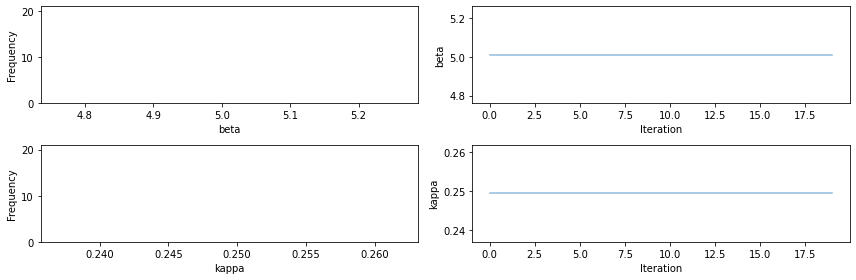

In [13]:
import pints.plot

# Plot histograms of the parameters inferred for South West
param_names=['beta', 'kappa']

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

In [14]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 10:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(samples))

[nan nan]


/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/pints/_diagnostics.py:235: RuntimeWarning: invalid value encountered in true_divide
  rhat = np.sqrt((n - 1.0) / n + b / (w * n))


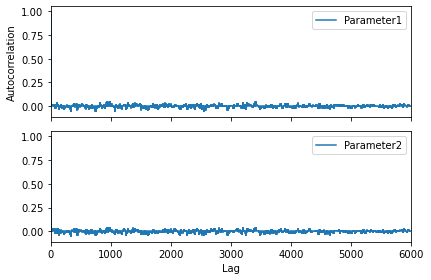

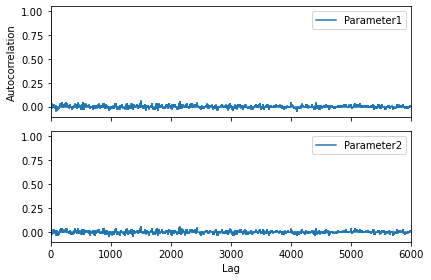

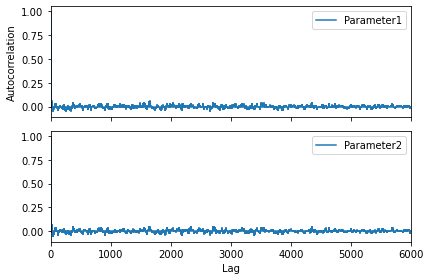

In [15]:
# Plot the autocorrelation for the three chains of parameters for South West
for sample in samples:
    pints.plot.autocorrelation(sample, max_lags=6000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [18]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

predicted_new_infec = []
predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    reg_predicted_new_infec = []
    reg_predicted_deaths = []
    reg_predicted_reprod_num = []

    parameters.simulation_parameters.region_index = r + 1

    for params in extended_samples[::thinning, :]:
        parameters.transmission_parameters.beta = params[0]
        parameters.transmission_parameters.kappa = params[1]

        #r_fix = np.empty(len(times))
        model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        model_output = model.simulate(parameters)

        model_reg_new_infections = model.new_infections(model_output)
        
        age_model_reg_new_deaths = model.new_deaths(model_output)

        for t, time in enumerate(times):
        #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
            model_reg_deaths_data[t] = np.sum(model.mean_deaths(t, age_model_reg_new_deaths))
        
        reg_predicted_new_infec.append(model_reg_new_infections)
        reg_predicted_deaths.append(model_reg_deaths_data)
        #reg_predicted_reprod_num.append(r_fix)

    reg_predicted_new_infec = np.array(reg_predicted_new_infec)

    predicted_new_infec.append(reg_predicted_new_infec)
    predicted_deaths.append(reg_predicted_deaths)
    #predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)


## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [19]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

In [20]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
#reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
#reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
#reprod_num_lower = []

for r, _ in enumerate(model.regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    #reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    #reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    #reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

### Plot observed versus predicted using model with inferred parameters

In [22]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=serology_times,
    #         y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
    #         mode='markers',
    #         name=trace_name[r],
    #         showlegend=False,
    #         line_color=colours[r]
    #     ),
    #     row= 1,
    #     col= 1
    # )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_data[r],
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    # fig.add_trace(
    #     go.Scatter(
    #         x=times,
    #         y=reprod_num_mean[r].tolist(),
    #         mode='lines',
    #         name=trace_name[r],
    #         showlegend=False,
    #         line_color=colours[r]
    #     ),
    #     row= 3,
    #     col= 1
    # )

    # fig.add_trace(
    #     go.Scatter(
    #         x=times + times[::-1],
    #         y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
    #         fill='toself',
    #         fillcolor=colours[r],
    #         line_color=colours[r],
    #         opacity=0.15,
    #         mode='lines',
    #         showlegend=False,
    #         name=trace_name[r]
    #     ),
    #     row= 3,
    #     col= 1
    # )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3-synthetic.pdf')
fig.show()